In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
from new_Adam import *
import no_gpu
import reproducible

In [4]:
import time

In [5]:
X_train, X_val, y_train, y_val = mnist_prep()

In [6]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 0s 175us/sample - loss: 2.0423 - accuracy: 0.3700 - val_loss: 1.6682 - val_accuracy: 0.5580
Epoch 2/5
1000/1000 [==============================] - 0s 107us/sample - loss: 1.2410 - accuracy: 0.6870 - val_loss: 1.0319 - val_accuracy: 0.7180
Epoch 3/5
1000/1000 [==============================] - 0s 108us/sample - loss: 0.6605 - accuracy: 0.8120 - val_loss: 0.6919 - val_accuracy: 0.8140
Epoch 4/5
1000/1000 [==============================] - 0s 113us/sample - loss: 0.3502 - accuracy: 0.9160 - val_loss: 0.5862 - val_accuracy: 0.8260
Epoch 5/5
1000/1000 [==============================] - 0s 104us/sample - loss: 0.1866 - accuracy: 0.9590 - val_loss: 0.4903 - val_accuracy: 0.8580
Overall calculation took 1.9375011920928955 seconds.
Model: "sequential"
________________________________________________________________

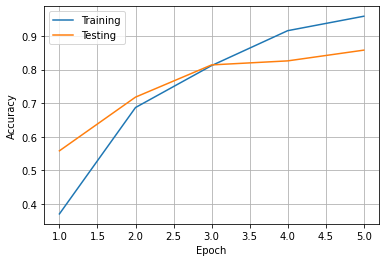

In [7]:
model = nn_model_structure(layers = 5,
                           neurons = [128, 128, 64, 32, 10],
                           n_cols = X_train_small.shape[1])
model = nn_model_compile(model,
                         optimizer = Adam_test())
start_time = time.time()
model = nn_model_fit(model,
                     X_train = X_train_small,
                     y_train = y_train_small,
                     X_val = X_val_small,
                     y_val = y_val_small,
                     batch_size = 100,
                     epochs = 5)
end_time = time.time()
print("Overall calculation took {} seconds.".format(end_time - start_time))
model.summary()
nn_plot_acc(model)
# nn_save(model, "../models/model_test_small.h5")

In [8]:
model.trainable_weights

[<tf.Variable 'dense/kernel:0' shape=(784, 128) dtype=float32>,
 <tf.Variable 'dense/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'dense_1/kernel:0' shape=(128, 128) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'dense_2/kernel:0' shape=(128, 64) dtype=float32>,
 <tf.Variable 'dense_2/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'dense_3/kernel:0' shape=(64, 32) dtype=float32>,
 <tf.Variable 'dense_3/bias:0' shape=(32,) dtype=float32>,
 <tf.Variable 'dense_4/kernel:0' shape=(32, 10) dtype=float32>,
 <tf.Variable 'dense_4/bias:0' shape=(10,) dtype=float32>]

In [9]:
model.history.history

{'loss': [2.042340099811554,
  1.2409830570220948,
  0.660470598936081,
  0.3501771867275238,
  0.1865655519068241],
 'accuracy': [0.37, 0.687, 0.812, 0.916, 0.959],
 'val_loss': [1.6681962251663207,
  1.0319476127624512,
  0.6919429421424865,
  0.5861680269241333,
  0.49026405811309814],
 'val_accuracy': [0.558, 0.718, 0.814, 0.826, 0.858]}

In [10]:
model.evaluate(X_val_small, y_val_small)

[0.4902640941143036, 0.858]

In [11]:
model.output

<tf.Tensor 'dense_4/Softmax:0' shape=(None, 10) dtype=float32>

In [12]:
for layer in model.layers:
    weights = layer.get_weights()
    print(weights)

[array([[-0.02594187, -0.0072834 , -0.01032349, ...,  0.01099001,
         0.02263252, -0.00540902],
       [-0.04240971,  0.01505729,  0.05052843, ..., -0.03955676,
         0.08247308, -0.05252915],
       [-0.02863339,  0.00354501, -0.03751646, ...,  0.01826481,
         0.01242398,  0.0209585 ],
       ...,
       [ 0.02623673, -0.00581976, -0.00234769, ..., -0.00671507,
         0.02205776,  0.04007986],
       [-0.07005067,  0.03381488, -0.06596353, ...,  0.0281436 ,
         0.00689889, -0.00241061],
       [-0.07230214, -0.04364245, -0.04888087, ..., -0.01412402,
         0.01797532,  0.00632063]], dtype=float32), array([ 8.50379020e-02,  6.79023787e-02, -1.44947797e-01,  7.18391081e-03,
        6.61825470e-04,  3.31637944e-04,  1.12835713e-01, -3.58737633e-02,
        8.49192217e-02, -8.95808935e-02,  1.39470413e-01,  1.45144343e-01,
        1.80908784e-01, -2.75218245e-02, -6.26497110e-03, -1.60265073e-01,
        6.65010884e-02, -4.19562533e-02,  4.84335050e-02,  1.05985239e

In [13]:
weights = model.get_weights()
print(weights)

[array([[-0.02594187, -0.0072834 , -0.01032349, ...,  0.01099001,
         0.02263252, -0.00540902],
       [-0.04240971,  0.01505729,  0.05052843, ..., -0.03955676,
         0.08247308, -0.05252915],
       [-0.02863339,  0.00354501, -0.03751646, ...,  0.01826481,
         0.01242398,  0.0209585 ],
       ...,
       [ 0.02623673, -0.00581976, -0.00234769, ..., -0.00671507,
         0.02205776,  0.04007986],
       [-0.07005067,  0.03381488, -0.06596353, ...,  0.0281436 ,
         0.00689889, -0.00241061],
       [-0.07230214, -0.04364245, -0.04888087, ..., -0.01412402,
         0.01797532,  0.00632063]], dtype=float32), array([ 8.50379020e-02,  6.79023787e-02, -1.44947797e-01,  7.18391081e-03,
        6.61825470e-04,  3.31637944e-04,  1.12835713e-01, -3.58737633e-02,
        8.49192217e-02, -8.95808935e-02,  1.39470413e-01,  1.45144343e-01,
        1.80908784e-01, -2.75218245e-02, -6.26497110e-03, -1.60265073e-01,
        6.65010884e-02, -4.19562533e-02,  4.84335050e-02,  1.05985239e

In [14]:
y_true, y_pred = nn_class_pred_true(model, X_val_small, y_val_small, print_comp = True)

Prediction: 6, Actual: 6, True
Prediction: 9, Actual: 9, True
Prediction: 5, Actual: 8, False
Prediction: 5, Actual: 5, True
Prediction: 9, Actual: 9, True
Prediction: 9, Actual: 9, True
Prediction: 7, Actual: 7, True
Prediction: 9, Actual: 9, True
Prediction: 3, Actual: 3, True
Prediction: 2, Actual: 2, True
Prediction: 2, Actual: 2, True
Prediction: 7, Actual: 7, True
Prediction: 1, Actual: 1, True
Prediction: 5, Actual: 5, True
Prediction: 6, Actual: 6, True
Prediction: 9, Actual: 9, True
Prediction: 8, Actual: 8, True
Prediction: 6, Actual: 2, False
Prediction: 7, Actual: 7, True
Prediction: 4, Actual: 4, True
Prediction: 2, Actual: 2, True
Prediction: 7, Actual: 7, True
Prediction: 7, Actual: 9, False
Prediction: 9, Actual: 9, True
Prediction: 5, Actual: 5, True
Prediction: 4, Actual: 4, True
Prediction: 7, Actual: 7, True
Prediction: 1, Actual: 1, True
Prediction: 5, Actual: 5, True
Prediction: 5, Actual: 5, True
Prediction: 8, Actual: 8, True
Prediction: 9, Actual: 9, True
Predi

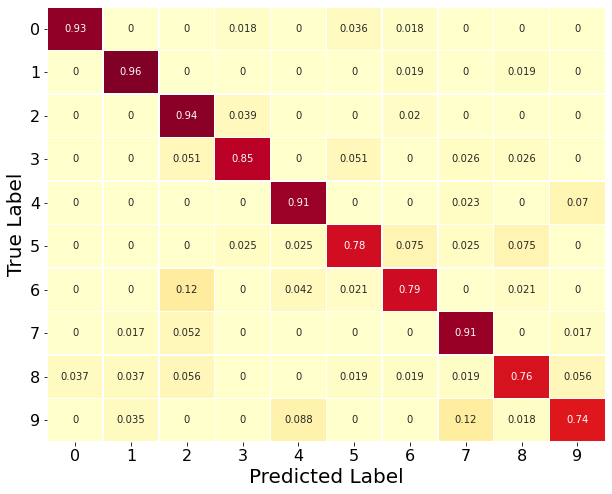

In [15]:
cm = nn_conf_mat(y_true, y_pred)

In [16]:
cm

array([[0.92857143, 0.        , 0.        , 0.01785714, 0.        ,
        0.03571429, 0.01785714, 0.        , 0.        , 0.        ],
       [0.        , 0.96296296, 0.        , 0.        , 0.        ,
        0.        , 0.01851852, 0.        , 0.01851852, 0.        ],
       [0.        , 0.        , 0.94117647, 0.03921569, 0.        ,
        0.        , 0.01960784, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.05128205, 0.84615385, 0.        ,
        0.05128205, 0.        , 0.02564103, 0.02564103, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.90697674,
        0.        , 0.        , 0.02325581, 0.        , 0.06976744],
       [0.        , 0.        , 0.        , 0.025     , 0.025     ,
        0.775     , 0.075     , 0.025     , 0.075     , 0.        ],
       [0.        , 0.        , 0.125     , 0.        , 0.04166667,
        0.02083333, 0.79166667, 0.        , 0.02083333, 0.        ],
       [0.        , 0.01724138, 0.0517241